# **Titanic: Models for Survival Prediction**
### Equipo 4:

*   Fabian Trejo
*   Miguel Bermea
*   Eduardo Martinez
*   Samantha Guanipa
*   Francia García
*   Alexia Naredo

# **Libraries and Data Loading**

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC

from sklearn import datasets
import pandas as pd
import numpy as np
import re

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
train = pd.read_csv('data4training.csv', index_col = 'PassengerId')
global test
test = pd.read_csv('test.csv')

In [44]:
global test1
test1 = test.copy()
PassengerId = test1['PassengerId']

In [45]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# **Preprocessing of Data**

In [46]:
def extract_text(text):
  '''
  Extracts text between ',' and '.' from provided string.

  Args:
      text (str): Text containing the wanted substring.

  Returns:
      (str): Text contained by the '.' and ',' separators, if found.
             Otherwise, it returns an empty string.
  '''
  match = re.search(r'(?<=(\,\s))[A-z]+(?=(\.))', text)
  if match:
    return match.group(0)
  return ''



def encoding(dataframe):
  '''
  This function creates dummy variables for each needed categorical column of the dataframe.

  Args:
      dataframe (pd.Dataframe): Data to be encoded.

  Returns:
      dataframe (pd.Dataframe): Dataframe with new binary columns for each
                                 category instead of original variables.
  '''

  dataframe['Pclass_3'] = dataframe['Pclass'].apply(lambda x: 1 if x == '3' else 0)
  dataframe['Sex_female'] = dataframe['Sex'].apply(lambda x: 1 if x == 'female' else 0)
  dataframe['Title_Master'] = dataframe['Title'].apply(lambda x: 1 if x == 'Master' else 0)
  dataframe['Title_Miss'] = dataframe['Title'].apply(lambda x: 1 if x == 'Miss' else 0)
  dataframe['Title_Mrs'] = dataframe['Title'].apply(lambda x: 1 if x == 'Mrs' else 0)

  dataframe.drop(columns = ['Pclass', 'Sex', 'Title'], inplace = True)

  return dataframe



def minmax_scaling(dataframe, min = {}, max = {}):
  '''
  Performs minmax scaling on all numerical data of a give dataframe.

  Args:
      dataframe (pd.Dataframe): Data to be scaled according to max and min values in
                                training set.
      min (dictionary): Dictionary min values for each variable.
      max (dictionary): Dictionary min values for each variable.

  Returns:
      dataframe_scale = Dataframe with scaled values.
  '''
  dataframe_scale = pd.DataFrame()

  # If min and max are not provided, current max and min of dataframe will be used.
  for column in dataframe.columns:
    if column not in min.keys():
      min_value = dataframe[column].min()
      max_value = dataframe[column].max()
    else:
      min_value = min[column]
      max_value = max[column]
    dataframe_scale[column] = dataframe[column].apply(lambda value: (value - min_value) / (max_value - min_value))

  return dataframe_scale



def preprocessing(dataframe):
  '''
  This function receives the raw dataframe and applies a number of transformations
  to use as input for the machine learning model.

  Args:
      dataframe (pd.Dataframe): Dataframe with all columns of passengers of the Titanic
                                with unknown "Survived" value.

  Returns:
      dataframe (pd.Dataframe): Modified dataframe ready to be used as input for predictions.
  '''
  relevant_features = ['Parch', 'Fare', 'Pclass_3', 'Sex_female', 'Title_Master', 'Title_Miss', 'Title_Mrs']

  # Selecting relevant columns. Correcting data types.
  dataframe = dataframe[['Parch', 'Fare', 'Pclass', 'Sex', 'Name']]
  dataframe = dataframe.astype({'Pclass':'string', 'Name':'string', 'Sex':'string'})

  # Creating new 'Title' column extracting the data from 'Name' to replace it.
  dataframe['Name'] = dataframe['Name'].astype('string')
  dataframe['Title'] = dataframe['Name'].apply(extract_text)
  dataframe = dataframe.copy()
  dataframe.drop(columns = ['Name'], inplace = True)

  # Encoding, scaling and selection
  dataframe = encoding(dataframe)
  dataframe = minmax_scaling(dataframe[relevant_features], min = {'Parch':0, 'Fare':0}, max = {'Parch':2, 'Fare':164.8667})

  return dataframe



In [47]:
test = preprocessing(test)

# **Converting the predictions into CSV files**

In [48]:
def convert_to_csv(nombre_archivo, y_pred):
    y_pred = y_pred.round().astype(int)
    y_pred_df = pd.DataFrame({'PassengerId': PassengerId,'Survived': y_pred})
    y_pred_df.to_csv(nombre_archivo +'.csv', index=False)

# **Implementation of Models**

### **1. Random Forest**

In [49]:
# Features
new_df = train.copy()


X_r = new_df.drop(['Survived'], axis=1)

# Labels
y_r = new_df[['Survived']]

In [50]:
# 60% of the data set is used to train and the other 40% used to test
X_train, X_test, y_train, y_test = train_test_split(X_r, y_r,
                                                    test_size = 0.4,
                                                    random_state = 1,
                                                    stratify = y_r)
y_r_array = y_r['Survived'].to_numpy()
y_train_array = y_train['Survived'].to_numpy()

In [51]:
print('Samples in y:', np.bincount(y_r_array.astype(int)))
print('Samples in y_train:', np.bincount(y_train_array.astype(int)))
print('Samples in y_test:', np.bincount(y_test['Survived'].astype(int)))

Samples in y: [407 293]
Samples in y_train: [244 176]
Samples in y_test: [163 117]


In [52]:
forest = RandomForestClassifier(n_estimators=550,
                                criterion='entropy',
                                max_features='sqrt',
                                max_depth=200)

forest.fit(X_train, y_train)

# Precision global de clasificación corecta
print('Train Accuracy : %.5f' % forest.score(X_train, y_train))
print('Test Accuracy : %.5f' % forest.score(X_test, y_test))

<ipython-input-52-dc1117d03529>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


Train Accuracy : 0.90952
Test Accuracy : 0.78929


In [53]:
y_pred = forest.predict(X_test)


In [54]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Precisión:", precision)
print("Recall:", recall)

Precisión: 0.7543859649122807
Recall: 0.7350427350427351


In [55]:
#test = test.fillna(0)
#y_pred1 = forest.predict(test)
#convert_to_csv('prediccion_random_forest', y_pred1)

### **2. Logistic Regression**

In [56]:
#Read training data

dfl = train.copy()

In [57]:
# Prepare the training dataset
X_train = train.drop(['Survived'], axis=1)
y_train = train['Survived']
test = pd.read_csv('test.csv')

In [58]:
#Process test data
# Extract titles from the 'Name' column in the test dataset
test['Title'] = test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Convert 'Sex' and 'Title' to numerical variables (one-hot encoding)
test['Sex_female'] = (test['Sex'] == 'female').astype(int)
test['Title_Master'] = (test['Title'] == 'Master').astype(int)
test['Title_Miss'] = (test['Title'] == 'Miss').astype(int)
test['Title_Mrs'] = (test['Title'] == 'Mrs').astype(int)

# Create 'Pclass_3' feature
test['Pclass_3'] = (test['Pclass'] == 3).astype(int)

# Normalize 'Fare'
scaler = StandardScaler()
test['Fare'] = scaler.fit_transform(test[['Fare']].fillna(test['Fare'].mean()))
# Use only the columns that are present in the training data
X_test = test[['Parch', 'Fare', 'Pclass_3', 'Sex_female', 'Title_Master', 'Title_Miss', 'Title_Mrs']]

# Handle any remaining missing values by mean imputation
X_test = X_test.fillna(X_test.mean())

In [59]:
# Fit the Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [60]:
# Perform 5-fold cross-validation on the training data
cv_scores = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)
std_cv_accuracy = np.std(cv_scores)

In [61]:
# Predict on the test set
y_pred = logistic_model.predict(X_test)

# Model coefficients and intercept
coefficients = logistic_model.coef_
intercept = logistic_model.intercept_

# Formatting the output variables for better readability
formatted_output = {
    'Mean CV Accuracy': f"{mean_cv_accuracy:.4f}",
    'Standard Deviation of CV Accuracy': f"{std_cv_accuracy:.4f}",
    'Model Coefficients': np.round(coefficients, 4).tolist()[0],
    'Model Intercept': f"{intercept[0]:.4f}"
}

formatted_output


{'Mean CV Accuracy': '0.7900',
 'Standard Deviation of CV Accuracy': '0.0210',
 'Model Coefficients': [-0.3154, 1.0128, -1.1695, 1.7271, 2.7, 0.676, 1.0512],
 'Model Intercept': '-0.9730'}

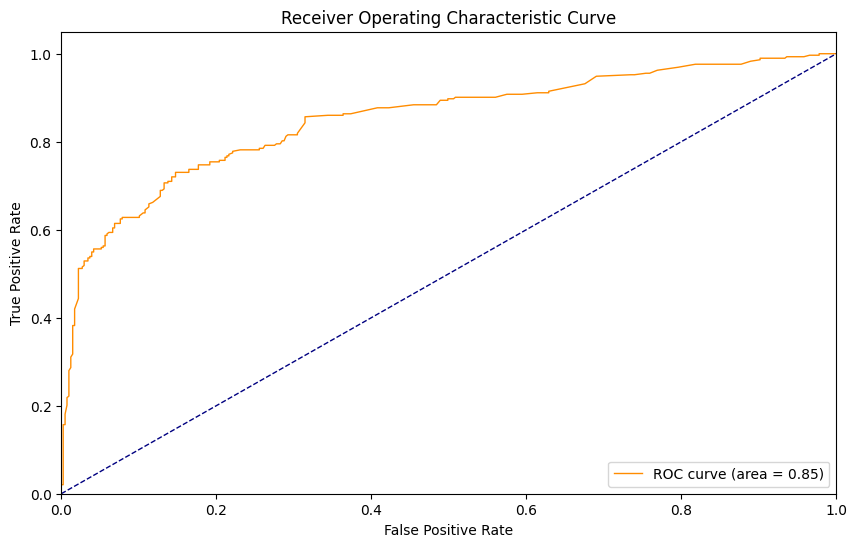

In [62]:
#Roc curve
# Calculate the ROC curve and AUC for the training set
fpr, tpr, _ = roc_curve(y_train, logistic_model.predict_proba(X_train)[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

### **3. K Nearest Neighbors**

In [63]:
#Read training data
df = train.copy()

In [64]:
# Split the data into features (X) and target (y)
X = df.drop('Survived', axis=1)
y = df['Survived']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size = 0.2)

# Scale the features using StandardScaler
scaler = sk.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [65]:
#Create a k-NN classifier with 3 neighbors: knn
knn = KNeighborsClassifier(n_neighbors=8)

#Fit the classifier to the training data
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=8)

In [66]:
y_pred = knn.predict(X_test)

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.94      0.83        77
         1.0       0.89      0.62      0.73        63

    accuracy                           0.79       140
   macro avg       0.82      0.78      0.78       140
weighted avg       0.81      0.79      0.79       140

[[72  5]
 [24 39]]


In [68]:
k_values = [i for i in range (1,31)]
scores = []

scaler = sk.preprocessing.StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = sk.model_selection.cross_val_score(knn, X, y, cv=5)
    #cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

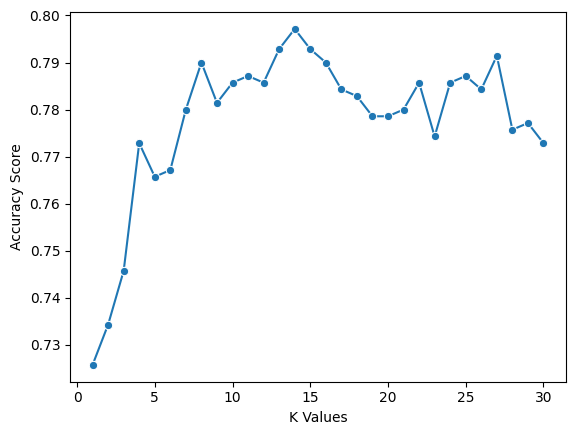

In [69]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [70]:
best_index = np.argmax(scores)
best_k = k_values[best_index]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=14)

In [71]:
y_pred = knn.predict(X_test)

accuracy = sk.metrics.accuracy_score(y_test, y_pred)
precision = sk.metrics.precision_score(y_test, y_pred)
recall = sk.metrics.recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8285714285714286
Precision: 0.9148936170212766
Recall: 0.6825396825396826


In [72]:
#test = test.fillna(0)
#y_pred2 = knn.predict(test)
#convert_to_csv('prediccion_k_nearest', y_pred2)

### **4. Support Vector Machine**

In [73]:
# Loading dataset and splitting into features and labels
df2 = train.copy()
X = df2.drop('Survived', axis=1)
Y = df2['Survived']

# Splitting into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Normalizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [74]:
# Training the SVM model with a rbf kernel
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_scaled, y_train)

SVC()

In [75]:
#Predicting on the test set
y_pred = svm_model.predict(X_test_scaled)

#Calculating accuracy and precision
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

Accuracy: 0.78
Precision: 0.77


In [76]:
#test = test.fillna(0)
#y_pred3 =  svm_model.predict(test)
#convert_to_csv('prediccion_support_vector_machine', y_pred3)